# Urban Sound Classification

The goal of this project is to introduce practice audio processing in the usual classification scenario with Data Handling in Audio domain. This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. We'll convert the audio files to spectrogram images and then classify them with fastai's vision learner.

# Libraries

In [1]:
import os
import glob
import shutil
import re
import numpy as np
from IPython.display import Image
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import specgram
%matplotlib inline

import librosa
import librosa.display

from fastai.vision.all import *

# Step 1: Extract data & audio

The data isn't included in the Github repository because it takes up too much space. The link to the data can be found at : https://datahack.analyticsvidhya.com/contest/practice-problem-urban-sound-classification/#ProblemStatement

All the data has been downloaded and stored in a folder named "Data Sources". Inside there are the files train.csv, test.csv, sample_submission.csv as well as the two folders train_audio and test_audio with the mp3 files inside. Two folders train_spectogram and test_spectogram will be generated afterwards.

In [4]:
train = pd.read_csv('../Urban Sound Classification/Data Sources/train.csv')
test = pd.read_csv('../Urban Sound Classification/Data Sources/test.csv')
sample_submission = pd.read_csv('../Urban Sound Classification/Data Sources/sample_submission.csv')

In [5]:
train['ID'] = train.ID.astype(str)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5435 entries, 0 to 5434
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5435 non-null   object
 1   Class   5435 non-null   object
dtypes: object(2)
memory usage: 85.0+ KB


In [6]:
train.head(5)

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [5]:
# listen a sound
import IPython.display as ipd
ipd.Audio(data="../Urban Sound Classification/Data Sources/train_audio/6.wav")

# Step 2: Create Spectograms

In [ ]:
os.mkdir('../Urban Sound Classification/Data Sources/train_spectrogram')
os.mkdir('../Urban Sound Classification/Data Sources/test_spectrogram')

In [ ]:
# create spectrograms for train set
spectrogram_path = Path('../Urban Sound Classification/Data Sources/train_spectrogram/')
audio_path = Path('../Urban Sound Classification/Data Sources/train_audio/')
for audio_file in list(Path(audio_path).glob('*.wav')):
    samples, sample_rate = librosa.load(audio_file)
    fig = plt.figure(figsize=[1,1])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    filename = spectrogram_path/Path(audio_file).name.replace('.wav', '.png')
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)
    plt.close()

In [7]:
# create spectrograms for test set
spectrogram_path = Path('../Urban Sound Classification/Data Sources/test_spectrogram/')
audio_path = Path('../Urban Sound Classification/Data Sources/test_audio/')
for audio_file in list(Path(audio_path).glob('*.wav')):
    samples, sample_rate = librosa.load(audio_file)
    fig = plt.figure(figsize=[1,1])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    filename = spectrogram_path/Path(audio_file).name.replace('.wav', '.png')
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

# Step 3: Assemble the data

The data is organized in an imageNet-style format.

In [9]:
# source path
source = ('../Urban Sound Classification/Data Sources/train_spectrogram/')

In [ ]:
# create directories
labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot', 'jackhammer','siren','street_music']

for label in labels:
    os.mkdir(source + label)

In [11]:
temp = files[0]; temp

'50.png'

In [17]:
train.loc[train.ID == re.findall(r"\d*", temp)[0], 'Class'].item()

'siren'

In [19]:
# get all files
files = os.listdir(source)

# sort images by label
for file in files:
    path = os.path.join(source, file)
    if os.path.isdir(path):
        # skip directories
        continue
    shutil.move(source + file, source + train.loc[train.ID == re.findall(r"\d*", file)[0], 'Class'].item())

In [11]:
dls = ImageDataLoaders.from_folder(source, valid_pct=0.2, item_tfms=Resize(300), 
                                   batch_tfms=Normalize.from_stats(*imagenet_stats), seed=707, num_workers=0)

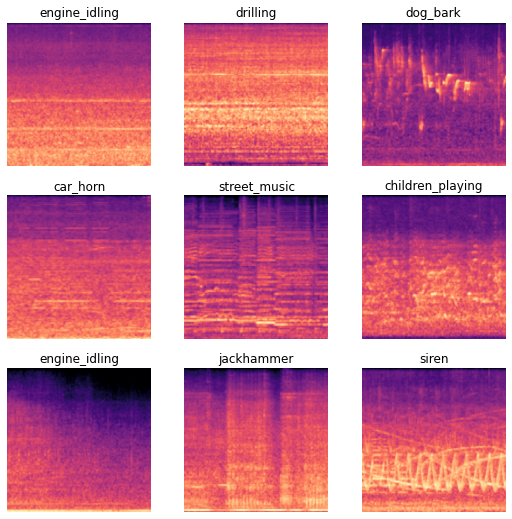

In [12]:
dls.show_batch()

# Step 4: Model

In [14]:
learn = Learner(dls,
                xresnet34(n_out=10), 
                metrics=accuracy)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.002511886414140463)

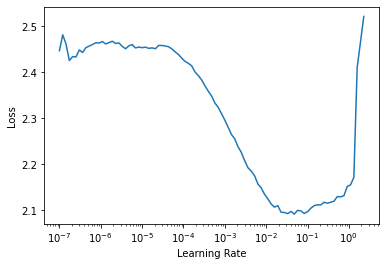

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(10, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,1.660520,1.375304,0.524379,01:27
1,1.181236,2.093810,0.411224,01:23
2,0.876239,0.810004,0.740570,01:23
3,0.578194,1.009524,0.676173,01:23
4,0.417410,0.378622,0.874885,01:24
5,0.290685,0.393403,0.875805,01:24
6,0.189045,0.201888,0.931923,01:23
7,0.121368,0.186607,0.934683,01:23
8,0.075905,0.130790,0.954922,01:25
9,0.052185,0.114390,0.964121,01:24


In [17]:
learn.save('base_model')

Path('../Urban Sound Classification/Data Sources/train_spectrogram/models/base_model.pth')

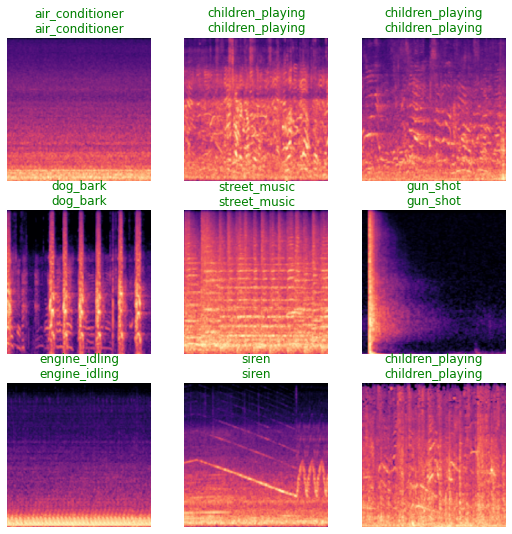

In [18]:
learn.show_results()

# Step 5: Optimization

## Changing the loss function

In [19]:
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

## Changing the optimizer

In [20]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(param_groups, **kwargs):
    return OptimWrapper(torch.optim.AdamW([{'params': ps, **kwargs} for ps in param_groups]))

## Changing the training loop with a Callback

In [21]:
from torch.distributions.beta import Beta

class Mixup(Callback):
    run_valid = False
    
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    
    def before_batch(self):
        self.t = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        x1,self.y1 = self.x[shuffle],self.y[shuffle]
        self.learn.xb = (x1 * (1-self.t[:,None,None,None]) + self.x * self.t[:,None,None,None],)
    
    def after_loss(self):
        with NoneReduce(self.loss_func) as lf:
            loss = lf(self.pred,self.y1) * (1-self.t) + lf(self.pred,self.y) * self.t
        self.learn.loss = loss.mean()

In [22]:
learn_opt = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(), cbs=Mixup(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3))

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0030199517495930195)

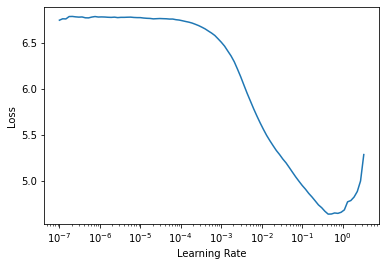

In [23]:
learn_opt.lr_find()

In [ ]:
learn_opt.fit_one_cycle(60, 0.04365158379077912)

epoch,train_loss,valid_loss,accuracy,time
0,2.879036,2.579506,0.406624,01:09
1,2.580856,2.320597,0.501380,01:09
2,2.421797,2.487273,0.494940,01:09
3,2.345573,2.921084,0.366145,01:09
4,2.258332,3.317461,0.342226,01:09
5,2.133874,2.166440,0.587856,01:09
6,2.091038,2.498415,0.414903,01:09
7,2.031880,1.716662,0.756210,01:09
8,1.939137,2.068898,0.673413,01:09
9,1.930572,1.850274,0.709292,01:09


In [ ]:
learn_opt.save('opt_model')

In [ ]:
learn_opt.show_results()

# Step 6: Predictions

In [ ]:
learn.predict('../Urban Sound Classification/Data Sources/train_spectrogram/416.pg')

In [ ]:
testdir = '../Urban Sound Classification/Data Sources/train_spectrogram/'

# get all files
test_files = os.listdir(testdir)

# sort images by label
for file in test_files:
    path = os.path.join(source, test_filesa)
    if os.path.isdir(path):
        # skip directories
        continue
    shutil.move(source + file, source + train.loc[train.ID == re.findall(r"\d*", file)[0], 'Class'].item())